In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from tqdm import tqdm, tqdm_notebook
from functools import reduce

def getSources():
    source_url = 'https://newsapi.org/v1/sources?language=en'
    response = requests.get(source_url).json()
    sources = []
    for source in response['sources']:
        sources.append(source['id'])
    return sources

def mapping():
    d = {}
    response = requests.get('https://newsapi.org/v1/sources?language=en')
    response = response.json()
    for s in response['sources']:
        d[s['id']] = s['category']
    return d

def category(source, m):
    try:
        return m[source]
    except:
        return 'NC'

def getDailyNews():
    sources = getSources()
    key = '93ce952dcfd5461186eec8885b840325'
    url = 'https://newsapi.org/v1/articles?source={0}&sortBy={1}&apiKey={2}'
    responses = []
    for i, source in tqdm_notebook(enumerate(sources), total=len(sources)):
        
        try:
            u = url.format(source, 'top', key)
        except:
            u = url.format(source, 'latest', key)
        
        response = requests.get(u)
        r = response.json()
        try:
            for article in r['articles']:
                article['source'] = source
            responses.append(r)
        except:
            print('Rate limit exceeded ... please wait and retry in 6 hours')
            return None
                
    articles = list(map(lambda r: r['articles'], responses))
    articles = list(reduce(lambda x,y: x+y, articles))
    
    news = pd.DataFrame(articles)
    news = news.dropna()
    news = news.drop_duplicates()
    news.reset_index(inplace=True, drop=True)
    d = mapping()
    news['category'] = news['source'].map(lambda s: category(s, d))
    news['scraping_date'] = datetime.now()

    try:
        aux = pd.read_csv('news.csv')
        aux = aux.append(news)
        aux = aux.drop_duplicates('url')
        aux.reset_index(inplace=True, drop=True)
        aux.to_csv('news.csv', encoding='utf-8', index=False)
    except:
        news.to_csv('news2.csv', index=False, encoding='utf-8')
        
    print('Done')
    
if __name__=='__main__':
    getDailyNews()

Rate limit exceeded ... please wait and retry in 6 hours



In [ ]:
# import packages
from __future__ import print_function
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

from collections import Counter
import re
import numpy as np

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

In [3]:
data = pd.read_csv('news.csv')
print(data.shape)

(2052, 9)


In [4]:
data.tail(10)

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
2042,"Rebecca Ballhaus, Siobhan Hughes, Dustin Volz",President also called on China to investigate ...,2019-10-04T16:14:00Z,the-wall-street-journal,Trump Administration Used Potential Meeting to...,https://www.wsj.com/articles/trump-administrat...,https://images.wsj.net/im-113846/social,business,2019-10-04 13:55:44.237614
2043,"Alexandra Bruell, Suzanne Vranica",Entertainment giants are set to spend hundreds...,2019-10-04T14:28:00Z,the-wall-street-journal,Disney Bans Netflix Ads as Streaming’s Marketi...,https://www.wsj.com/articles/disney-bans-netfl...,https://images.wsj.net/im-113163/social,business,2019-10-04 13:55:44.237614
2044,"Natasha Khan, Joyu Wang",Leader Carrie Lam invokes colonial-era emergen...,2019-10-04T07:38:00Z,the-wall-street-journal,Street Battles Break Out After Hong Kong Bans ...,https://www.wsj.com/articles/hong-kong-says-up...,https://images.wsj.net/im-113863/social,business,2019-10-04 13:55:44.237614
2045,"Melanie Evans, Anna Wilde Mathews","Genetic scans provide lots of information, but...",2019-10-04T15:16:00Z,the-wall-street-journal,Doctors Decide What To Tell Patients About The...,https://www.wsj.com/articles/doctors-decide-wh...,https://images.wsj.net/im-113502/social,business,2019-10-04 13:55:44.237614
2046,Alex Leary,Raises $45 million online for re-election bid ...,2019-10-04T15:52:00Z,the-wall-street-journal,Trump’s Online Fundraising Surges,https://www.wsj.com/articles/trump-re-election...,https://images.wsj.net/im-113822/social,business,2019-10-04 13:55:44.237614
2047,Dustin Volz,The Democratic National Committee sent an aler...,2019-10-04T16:11:00Z,the-wall-street-journal,Presidential Campaign Targeted by Suspected Ir...,https://www.wsj.com/articles/presidential-camp...,https://images.wsj.net/im-113845/social,business,2019-10-04 13:55:44.237614
2048,Jason Zweig,Schwab made a big splash this past week by eli...,2019-10-04T14:33:00Z,the-wall-street-journal,Your Stock Trades Go Free but Your Cash Is in ...,https://www.wsj.com/articles/your-stock-trades...,https://si.wsj.net/public/resources/images/B3-...,business,2019-10-04 13:55:44.237614
2049,Azra Raza,"Most patients continue to face excruciating, i...",2019-10-04T16:25:00Z,the-wall-street-journal,Cancer Is Still Beating Us—We Need a New Start,https://www.wsj.com/articles/cancer-is-still-b...,https://si.wsj.net/public/resources/images/B3-...,business,2019-10-04 13:55:44.237614
2050,CHRISTOPHER RUGABER / AP,"U.S. employers added a modest 136,000 jobs in ...",2019-10-04T14:07:19Z,time,"Unemployment Rate Hits 50-Year Low, But Hiring...",http://time.com/5692797/september-jobs-numbers/,https://timedotcom.files.wordpress.com/2019/10...,general,2019-10-04 13:55:44.237614
2051,YURAS KARMANAU / AP,Ukraine’s prosecutors office is reviewing prev...,2019-10-04T13:51:41Z,time,Ukraine Reviews Closed Case Into Gas Company T...,http://time.com/5692777/ukraine-gas-company-ca...,https://timedotcom.files.wordpress.com/2019/10...,general,2019-10-04 13:55:44.237614


In [5]:
data.category.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(8, 5))

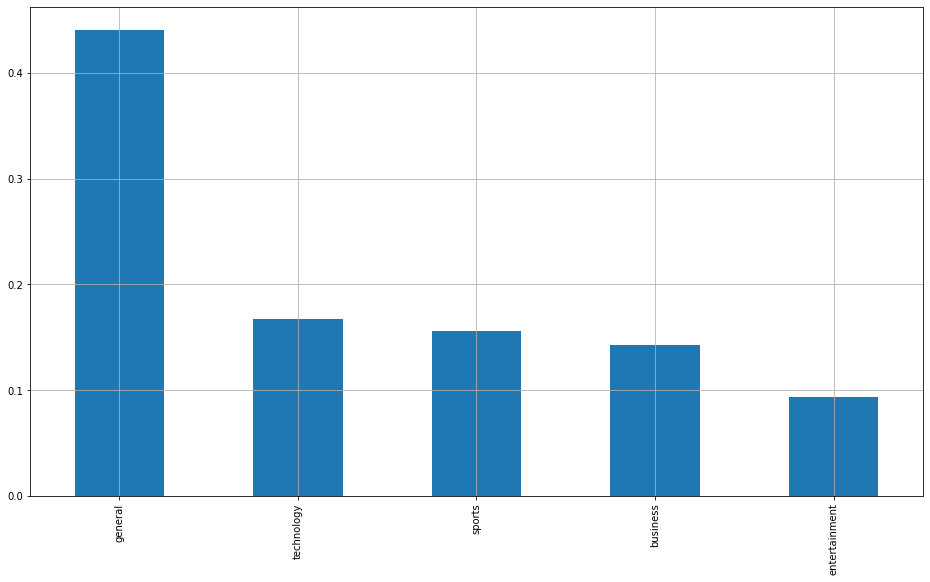

In [6]:
data.category.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

In [7]:
data = data.drop_duplicates('description')

In [8]:
data = data[~data['description'].isnull()]

print(data.shape)

(1936, 9)


In [9]:
data = data[(data.description.map(len) > 140) & (data.description.map(len) <= 300)]
data.reset_index(inplace=True, drop=True)

print(data.shape)

(834, 9)


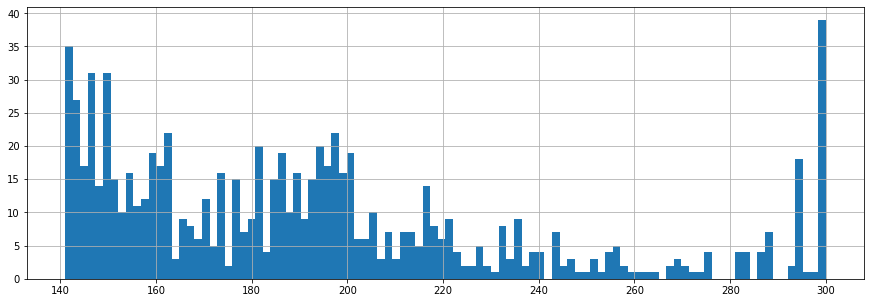

In [10]:
data.description.map(len).hist(figsize=(15, 5), bins=100)

In [11]:
data = data.sample(400, random_state=42)
data.reset_index(inplace=True, drop=True)

data.head(5)

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,SYLVIE CORBET and LORI HINNANT,PARIS (AP) — An employee armed with a knife at...,2019-10-03T11:54:57Z,associated-press,Knife attack by employee at Paris police HQ ki...,https://apnews.com/6cf2774600ca4ef3a517d84a351...,https://storage.googleapis.com/afs-prod/media/...,general,2019-10-03 09:58:28.267961
1,Megan Rose Dickey,"Stephen Curry, along with SC 30, Inc. Presiden...",2019-10-04T16:00:22Z,techcrunch,Stephen Curry invests in Guild Education,https://techcrunch.com/2019/10/04/stephen-curr...,https://techcrunch.com/wp-content/uploads/2019...,technology,2019-10-04 13:55:44.237614
2,Dan Bloom,Lindsay Hoyle and Harriet Harman are among the...,2019-09-10T14:25:24Z,mirror,All the candidates to be Speaker after John Be...,https://www.mirror.co.uk/news/politics/who-rep...,https://i2-prod.mirror.co.uk/incoming/article1...,general,2019-09-10 12:48:21.852603
3,Adam Maya,"Saquon Barkley, who's been determined to beat ...",2019-10-04T16:49:00Z,nfl-news,Giants RB Saquon Barkley ruled out versus Vikings,http://www.nfl.com/news/story/0ap3000001061893...,http://static.nfl.com/static/content/public/ph...,sports,2019-10-04 13:55:44.237614
4,Silvia Amaro,U.S. government debt prices were lower Tuesday...,2019-09-10T09:10:41Z,cnbc,US Treasury yields higher ahead of fresh data,https://www.cnbc.com/2019/09/10/us-treasury-yi...,https://image.cnbcfm.com/api/v1/image/10607734...,business,2019-09-10 07:39:46.933801


In [12]:
stop_words = []

f = open('./data/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

print(len(stop_words))

669


In [13]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [14]:
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [15]:
def keywords(category):
    tokens = data[data['category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz = vectorizer.fit_transform(list(data['tokens'].map(lambda tokens: ' '.join(tokens))))

vz.shape

KeyError: 'tokens'